# LSTM Forecasting Master Script


In [2]:
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Data Ingestion

In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

# Define the cryptocurrency pairs
crypto_pairs = {
    "Bitcoin": "XXBTZUSD",
    "Ethereum": "XETHZUSD",
    "Cardano": "ADAUSD",
    "Polkadot": "DOTUSD",
    "Litecoin": "XLTCZUSD",
    "Chainlink": "LINKUSD",
    "Polygon": "MATICUSD",
    "Solana": "SOLUSD",
    "Ripple": "XXRPZUSD",
    "Dogecoin": "DOGEUSD"
}

# Kraken API Endpoint
BASE_URL = "https://api.kraken.com/0/public/OHLC"

# Define the timeframe (1 day = 1440 minutes)
TIMEFRAME = 1440

# Calculate the start time (3 years ago)
start_time = int((datetime.utcnow() - timedelta(days=3*365)).timestamp())

# Fetch data function
def fetch_ohlc_data(pair, interval, since):
    params = {
        "pair": pair,
        "interval": interval,
        "since": since
    }
    response = requests.get(BASE_URL, params=params)
    data = response.json()

    if 'error' in data and data['error']:
        print(f"Error fetching data for {pair}: {data['error']}")
        return None

    key = list(data['result'].keys())[0]  # Extract the correct key from the response
    return data['result'][key]

# Process and save data
all_data = {}

for name, pair in crypto_pairs.items():
    print(f"Fetching data for {name} ({pair})...")
    ohlc_data = fetch_ohlc_data(pair, TIMEFRAME, start_time)

    if ohlc_data:
        df = pd.DataFrame(ohlc_data, columns=["Timestamp", "Open", "High", "Low", "Close", "VWAP", "Volume", "Count"])
        df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")  # Convert to readable date
        all_data[name] = df
        df.to_csv(f"{name}_ohlc_data.csv", index=False)
        print(f"Data saved for {name}!")

    time.sleep(2)  # Avoid hitting API rate limits

print("All data has been fetched and saved!")


In [ ]:
import pandas as pd
import os

# 🔧 List of your crypto CSVs (ensure the names match)
crypto_names = [
    "Bitcoin", "Ethereum", "Litecoin", "Ripple", "Cardano", "Polkadot",
    "Polygon", "Chainlink", "Dogecoin", "Solana"
]

combined_df = pd.DataFrame()

for name in crypto_names:
    file_path = f"{name}_ohlc_data.csv"
    if os.path.exists(file_path):
        print(f"✅ Merging {file_path}...")
        temp_df = pd.read_csv(file_path)
        temp_df["Crypto"] = name
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)
    else:
        print(f"⚠️ Missing file: {file_path}")

# ✅ Save merged dataset
combined_df.to_csv("crypto_data.csv", index=False)
print("🎉 Merged data saved to crypto_data.csv")

# Preprocessing And Feature Engineering

In [ ]:
import numpy as np

# 🔄 Load the combined dataset
df = pd.read_csv("crypto_data.csv")
df = df.sort_values(by=["Crypto", "Timestamp"])

# Convert data types
for col in ["Open", "High", "Low", "Close", "VWAP", "Volume"]:
    df[col] = df[col].astype(float)

# Feature Engineering
df["Volatility"] = df["High"] - df["Low"]
df["Price_Change"] = df["Close"] - df["Open"]

# RSI Calculation (Rolling)
df["RSI"] = df.groupby("Crypto")["Close"].transform(lambda x: x.rolling(14).apply(
    lambda s: 100 - (100 / (1 + (s.diff().clip(lower=0).mean() / s.diff().clip(upper=0).abs().mean())))
    if s.diff().clip(upper=0).abs().mean() != 0 else 0))

# Moving Averages
df["EMA_7"] = df.groupby("Crypto")["Close"].transform(lambda x: x.ewm(span=7).mean())
df["EMA_14"] = df.groupby("Crypto")["Close"].transform(lambda x: x.ewm(span=14).mean())
df["MA_7"] = df.groupby("Crypto")["Close"].transform(lambda x: x.rolling(7).mean())
df["MA_14"] = df.groupby("Crypto")["Close"].transform(lambda x: x.rolling(14).mean())

# Rolling Standard Deviations
df["Rolling_Std_7"] = df.groupby("Crypto")["Close"].transform(lambda x: x.rolling(7).std())
df["Rolling_Std_14"] = df.groupby("Crypto")["Close"].transform(lambda x: x.rolling(14).std())

# Lag Features
df["Close_Lag_1"] = df.groupby("Crypto")["Close"].shift(1)
df["Close_Lag_2"] = df.groupby("Crypto")["Close"].shift(2)
df["Close_Lag_3"] = df.groupby("Crypto")["Close"].shift(3)

# MACD
df["MACD"] = df["EMA_7"] - df["EMA_14"]

# Date Features
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Day_of_Week"] = df["Timestamp"].dt.dayofweek
df["Month"] = df["Timestamp"].dt.month
df["Week_of_Year"] = df["Timestamp"].dt.isocalendar().week

# Clean nulls
df.dropna(inplace=True)

# ✅ Save final feature-engineered dataset
df.to_csv("FINAL_DATA.csv", index=False)
print("✅ Feature-engineered data saved as FINAL_DATA.csv")


## 📂 Load the Final Feature-Engineered Dataset

In [3]:
df = pd.read_csv("FINAL_DATA.csv")
df.head()

,Timestamp,Open,High,Low,Close,VWAP,Volume,Count,Crypto,Volatility,...,Close_Lag_2,Close_Lag_3,Rolling_Std_7,Rolling_Std_14,EMA_7,EMA_14,MACD,Day_of_Week,Month,Week_of_Year
0,2023-03-08,22194.8,22267.9,21600.0,21699.1,21970.0,2475.224370,28049,Bitcoin,667.9,...,22409.4,22426.9,528.172436,676.084522,22379.157190,22789.068300,-409.911110,2,3,10
1,2023-03-09,21696.5,21819.0,20042.3,20363.6,21055.3,5826.279918,45307,Bitcoin,1776.7,...,22196.9,22409.4,752.721845,902.811497,21875.267893,22465.672527,-590.404634,3,3,10
2,2023-03-10,20363.7,20364.0,19549.9,20224.7,19979.6,8017.548035,51367,Bitcoin,814.1,...,21699.1,22196.9,970.734540,1099.062158,21462.625919,22166.876190,-704.250271,4,3,10
3,2023-03-11,20224.7,20879.0,19888.0,20616.4,20391.4,9219.865369,78209,Bitcoin,991.0,...,20363.6,21699.1,988.662827,1181.711526,21251.069440,21960.146031,-709.076592,5,3,10
4,2023-03-12,20619.7,22299.9,20440.3,22157.5,21235.1,7395.001226,60425,Bitcoin,1859.6,...,20224.7,20363.6,947.293055,1122.512473,21477.677080,21986.459894,-508.782814,6,3,10


# Insights

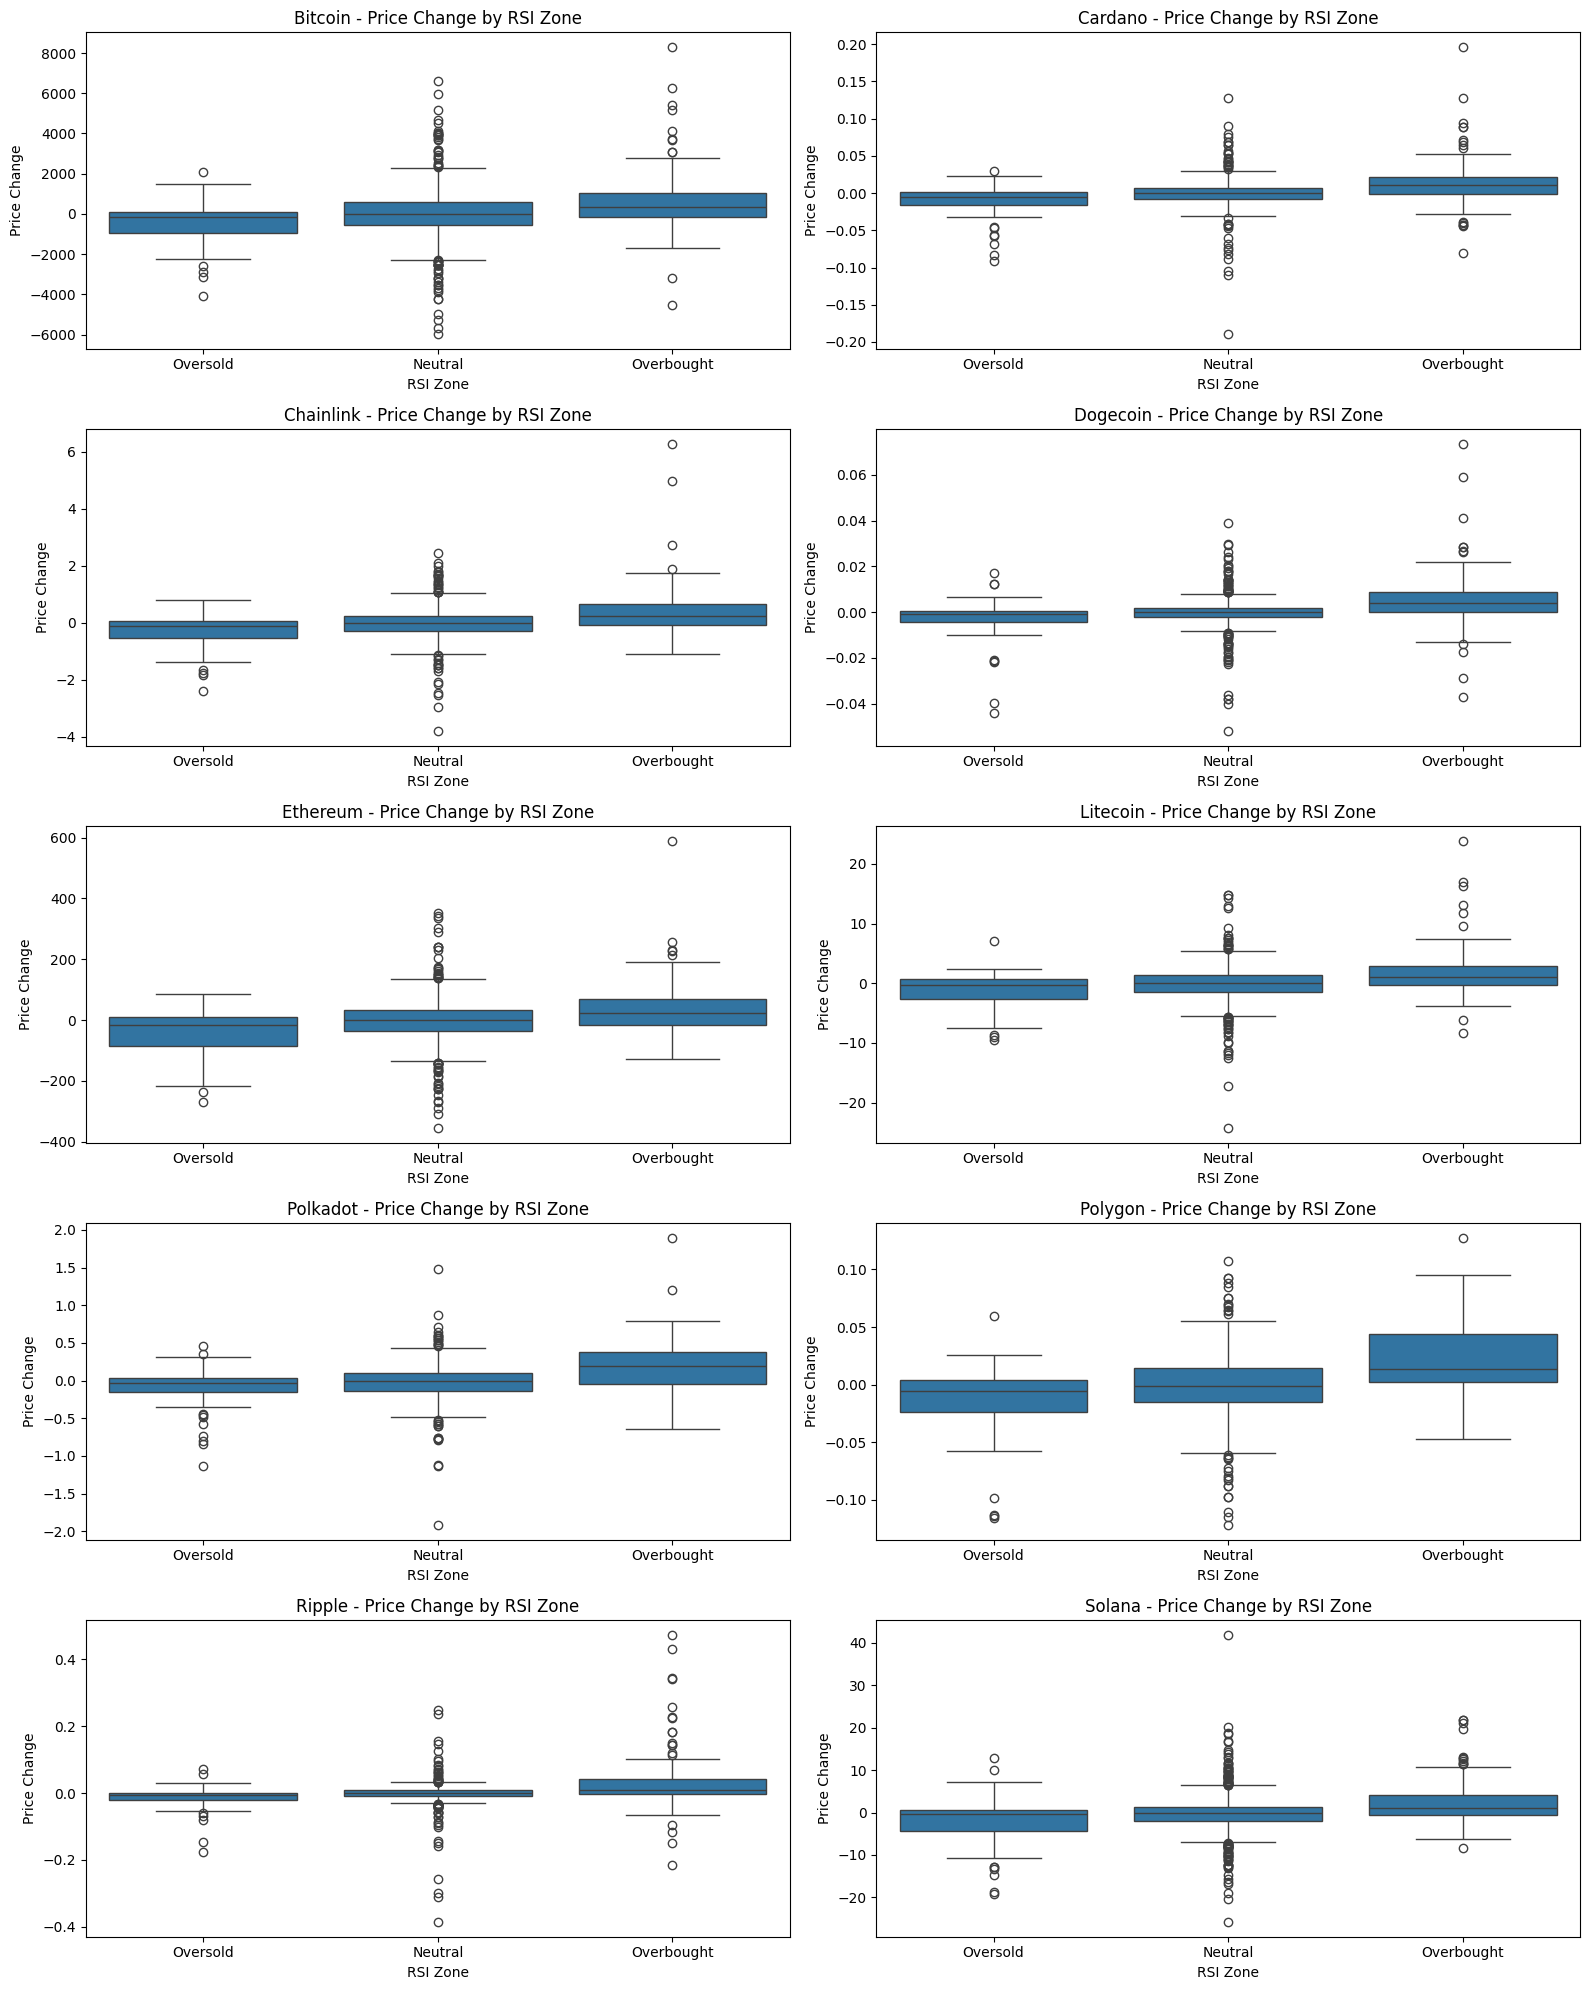

In [4]:
# Load final dataset
df = pd.read_csv("FINAL_DATA.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# RSI Zone vs Price Change
import matplotlib.pyplot as plt
import seaborn as sns

cryptos = df['Crypto'].unique()
fig, axes = plt.subplots(nrows=(len(cryptos) + 1) // 2, ncols=2, figsize=(16, 4 * ((len(cryptos) + 1) // 2)))
axes = axes.flatten()

for i, coin in enumerate(cryptos):
    coin_df = df[df['Crypto'] == coin].copy()
    coin_df['RSI_Zone'] = pd.cut(coin_df['RSI'], bins=[0, 30, 70, 100], labels=['Oversold', 'Neutral', 'Overbought'])
    sns.boxplot(data=coin_df, x='RSI_Zone', y='Price_Change', ax=axes[i])
    axes[i].set_title(f"{coin} - Price Change by RSI Zone")
    axes[i].set_xlabel("RSI Zone")
    axes[i].set_ylabel("Price Change")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

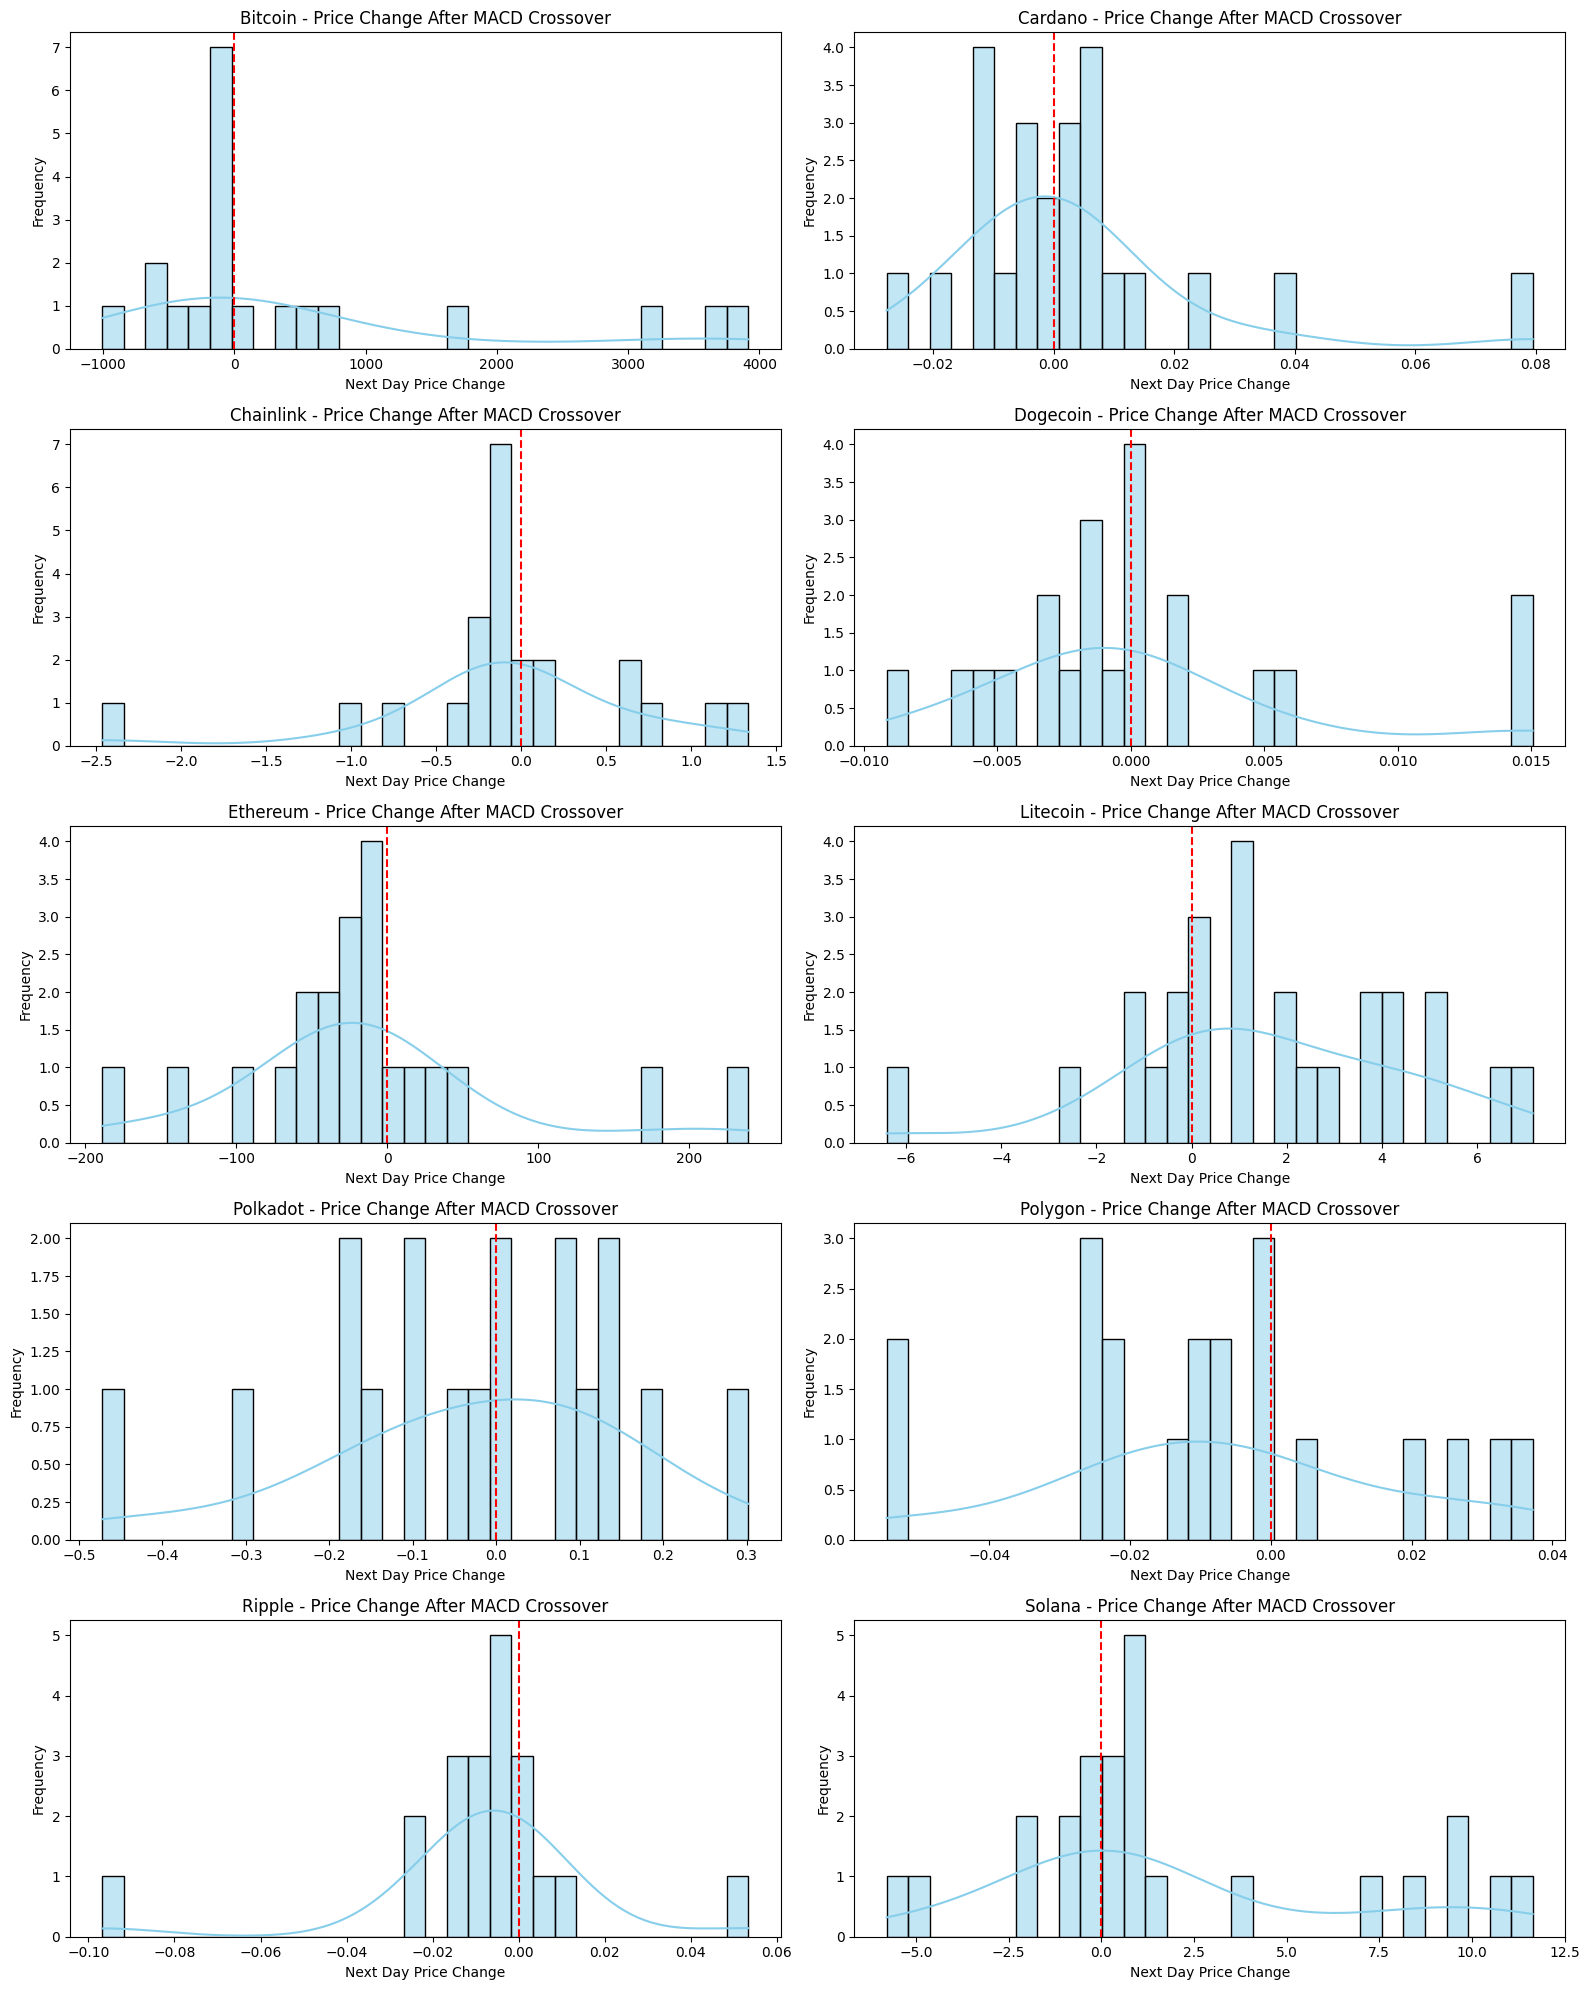

In [11]:
# Create a column that captures MACD crossover events (crossing zero line)
df['MACD_Crossover'] = (df['MACD'].shift(1) < 0) & (df['MACD'] > 0)

# Calculate price change after MACD crossover (next day change)
macd_events = df[df['MACD_Crossover'] == True].copy()
macd_events['Next_Day_Change'] = df['Price_Change'].shift(-1).loc[macd_events.index]

# Create subplots for each crypto showing price change after MACD crossover
cryptos = macd_events['Crypto'].unique()
num_coins = len(cryptos)
fig, axes = plt.subplots(nrows=(num_coins + 1) // 2, ncols=2, figsize=(16, 4 * ((num_coins + 1) // 2)))
axes = axes.flatten()

for i, coin in enumerate(cryptos):
    coin_df = macd_events[macd_events['Crypto'] == coin]
    sns.histplot(coin_df['Next_Day_Change'], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].axvline(0, color='red', linestyle='--')
    axes[i].set_title(f"{coin} - Price Change After MACD Crossover")
    axes[i].set_xlabel("Next Day Price Change")
    axes[i].set_ylabel("Frequency")

# Hide unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\Users\anand\AppData\Local\Temp\ipykernel_17332\2960028206.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\anand\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


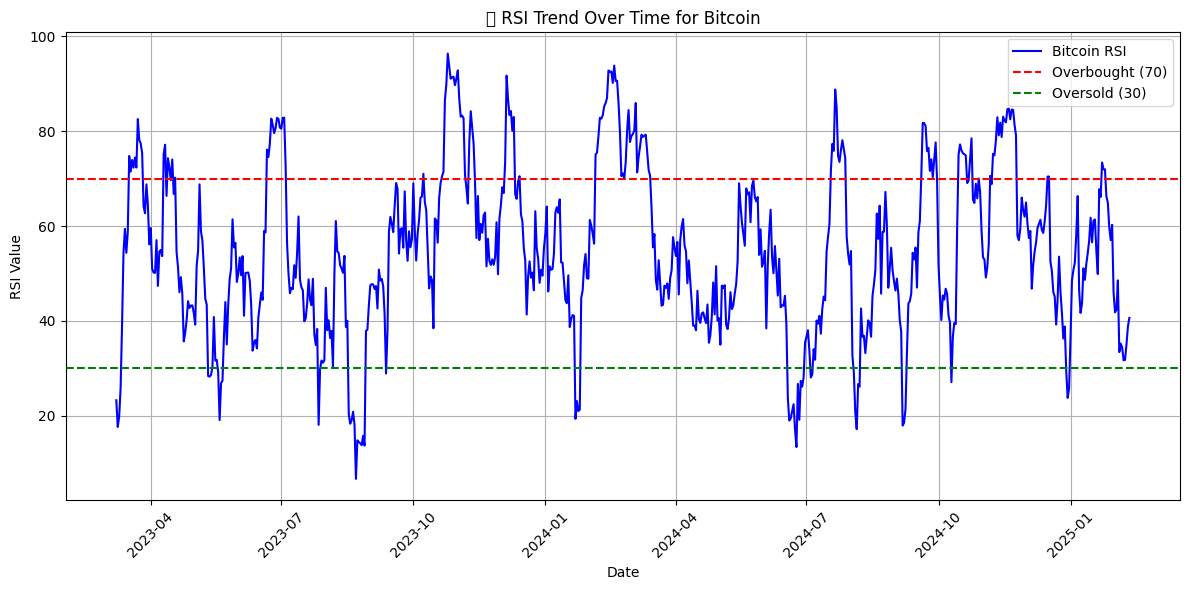

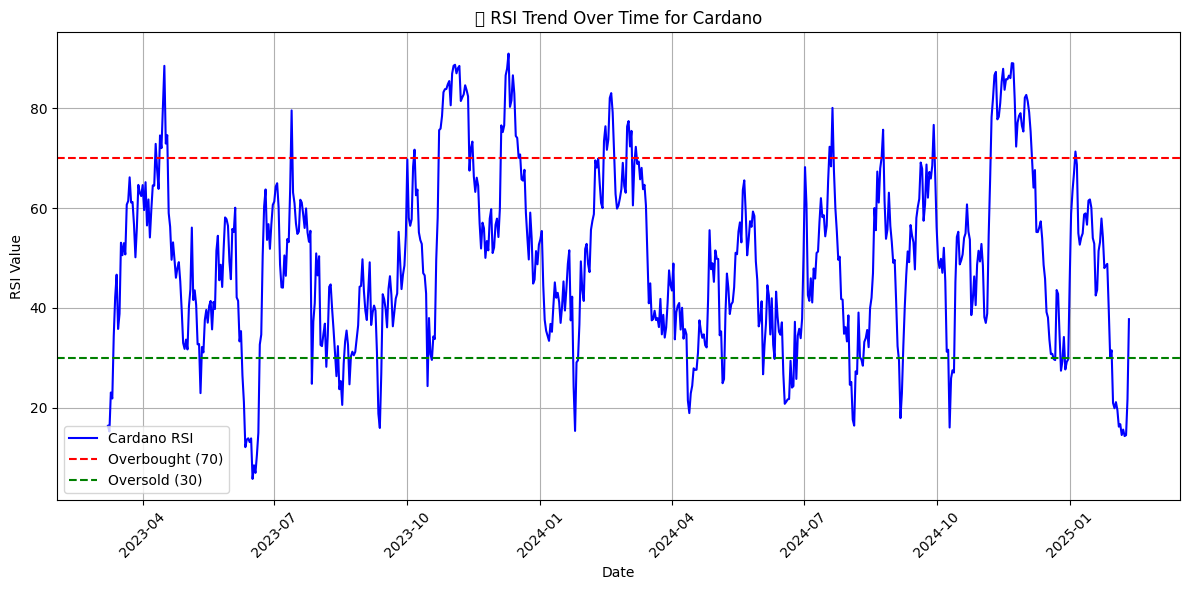

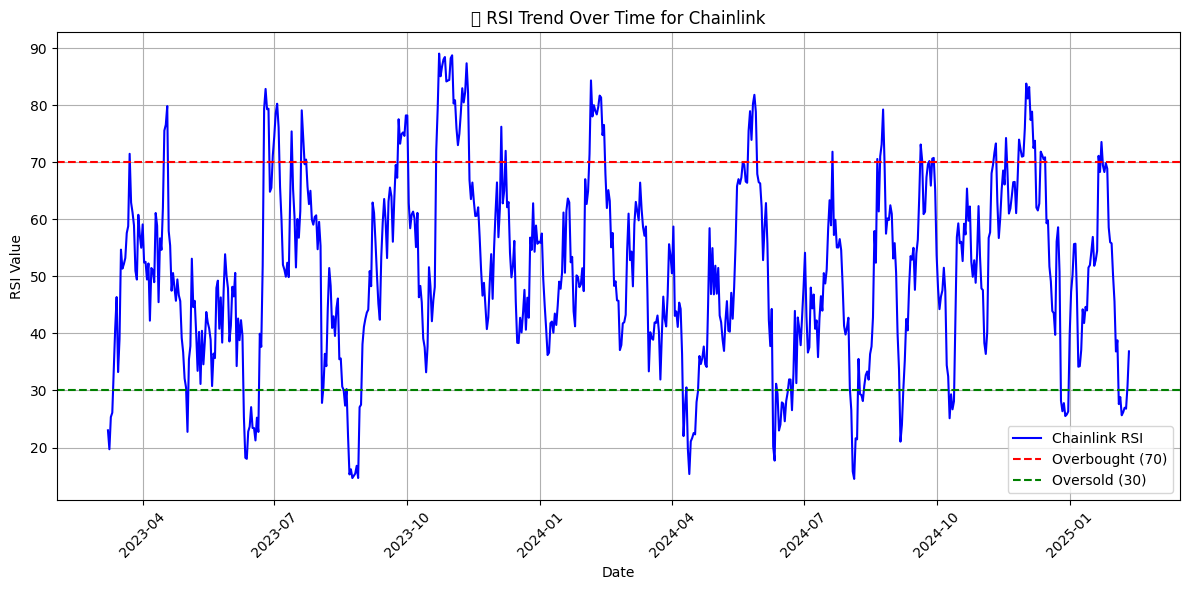

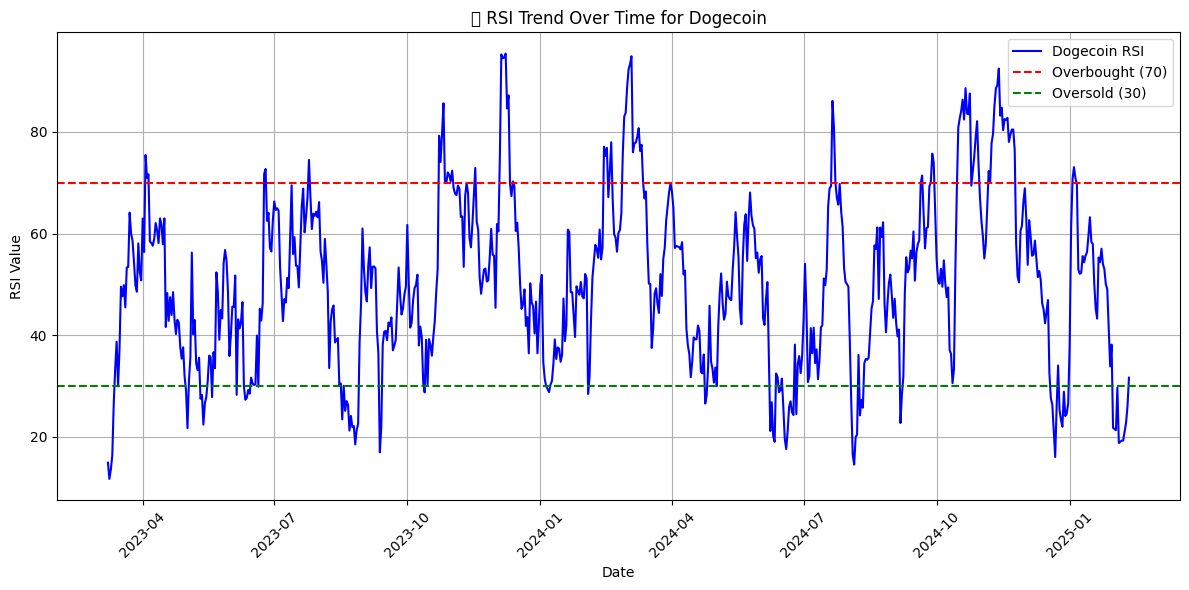

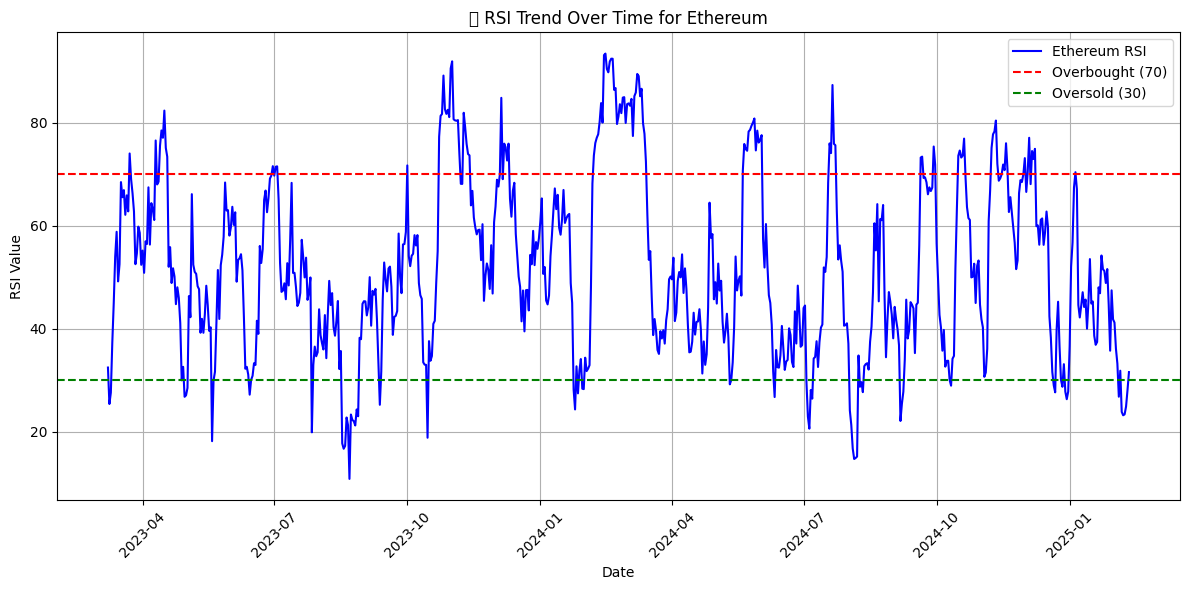

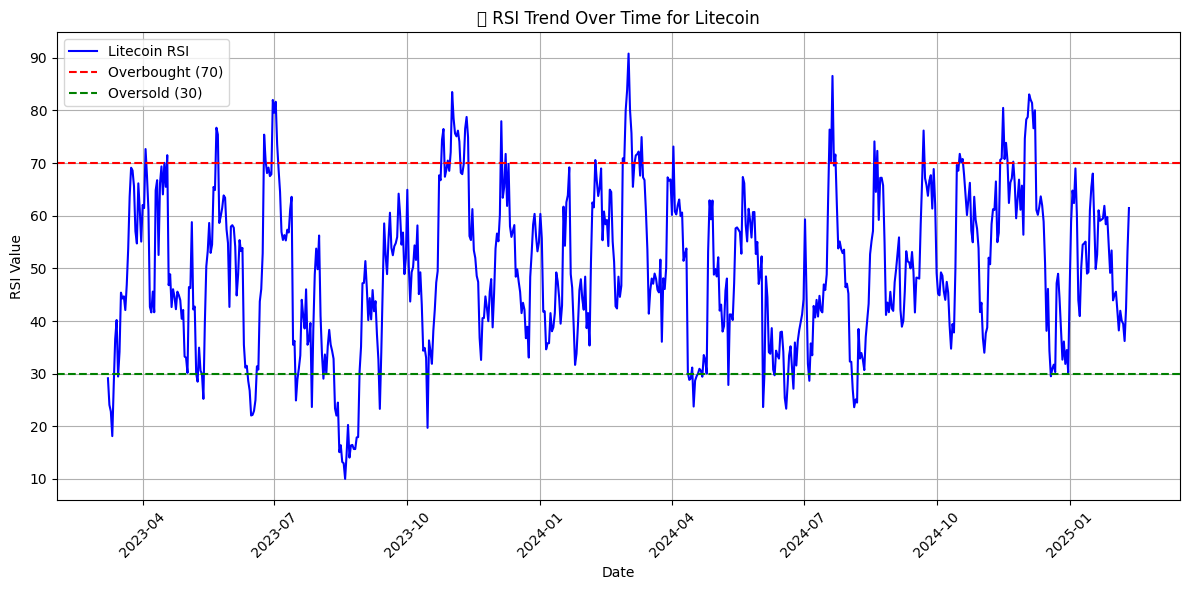

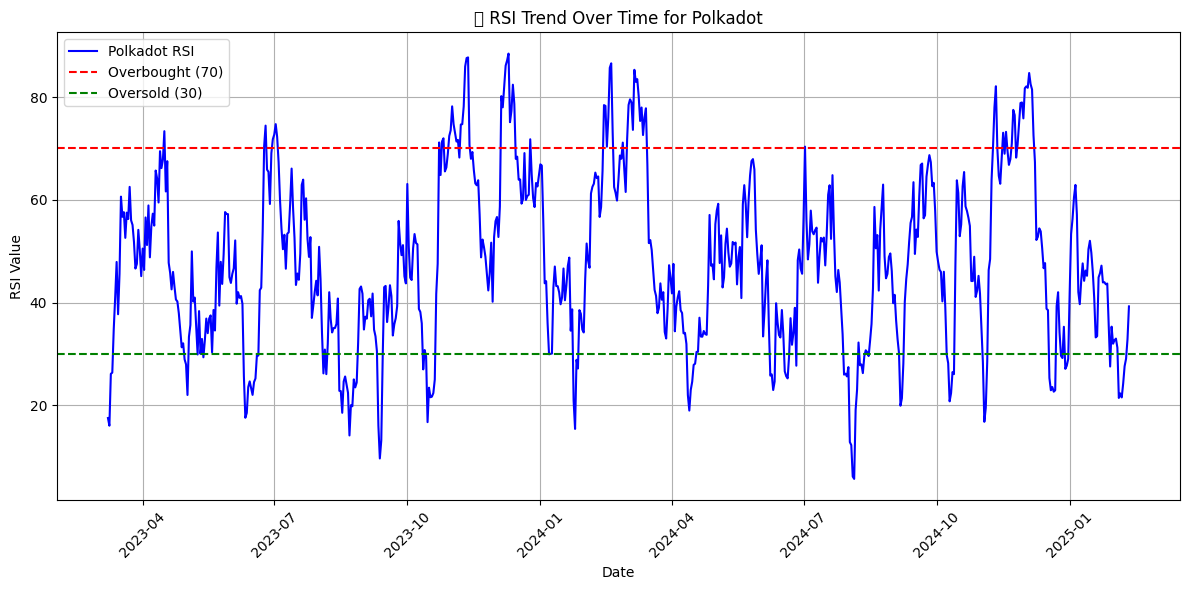

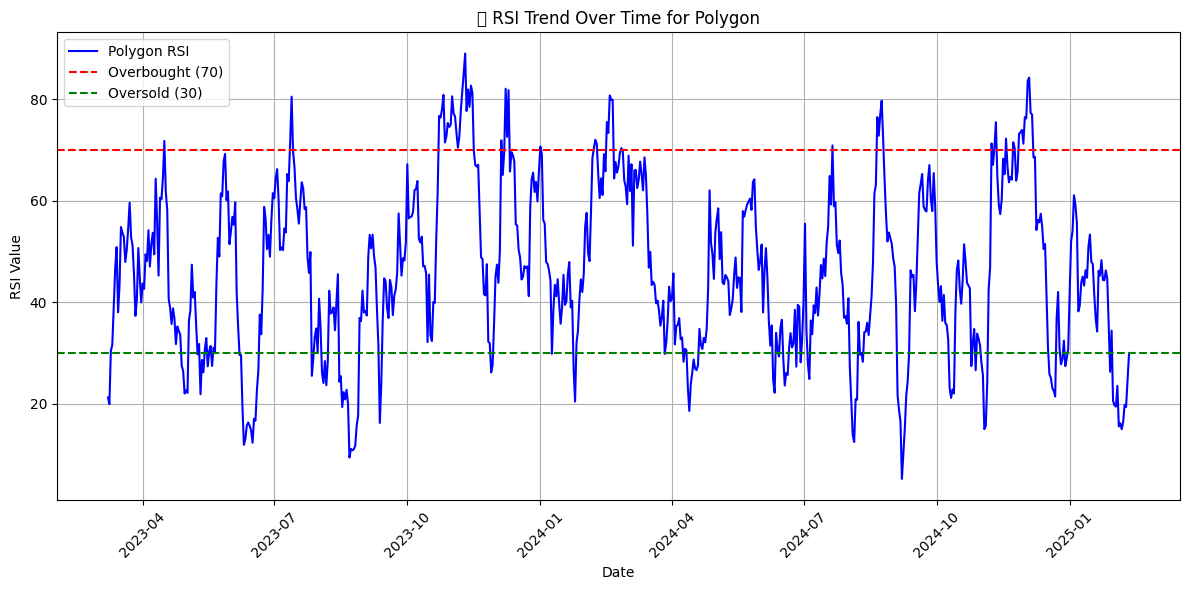

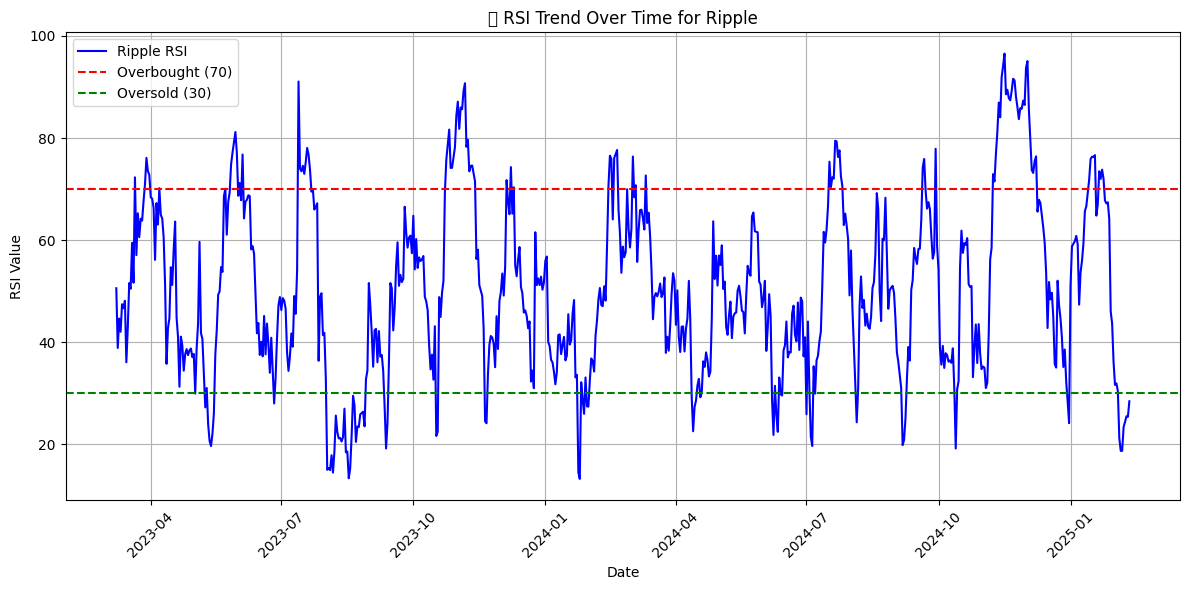

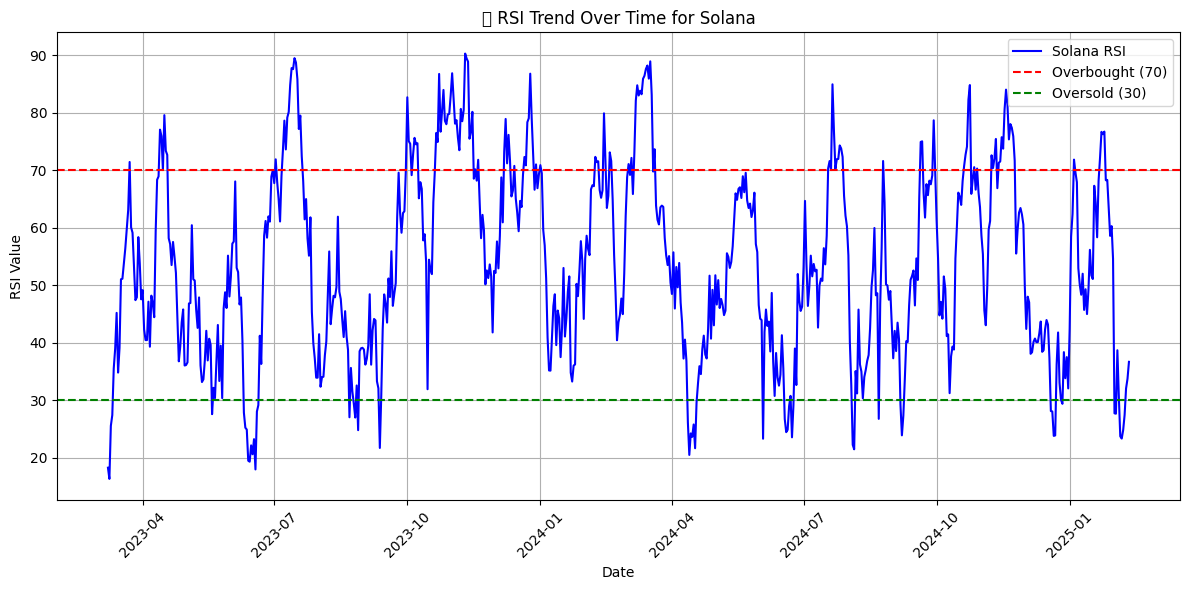

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

rsi_df = df[["Crypto", "Timestamp", "RSI"]].copy()
rsi_df["Timestamp"] = pd.to_datetime(rsi_df["Timestamp"])

# Unique coins
cryptos = rsi_df["Crypto"].unique()

# Plot RSI over time
for crypto in cryptos:
    crypto_data = rsi_df[rsi_df["Crypto"] == crypto]

    plt.figure(figsize=(12, 6))
    plt.plot(crypto_data["Timestamp"], crypto_data["RSI"], label=f"{crypto} RSI", color="blue")

    # Highlight overbought/oversold
    plt.axhline(70, color='red', linestyle='dashed', label="Overbought (70)")
    plt.axhline(30, color='green', linestyle='dashed', label="Oversold (30)")

    plt.title(f"📈 RSI Trend Over Time for {crypto}")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


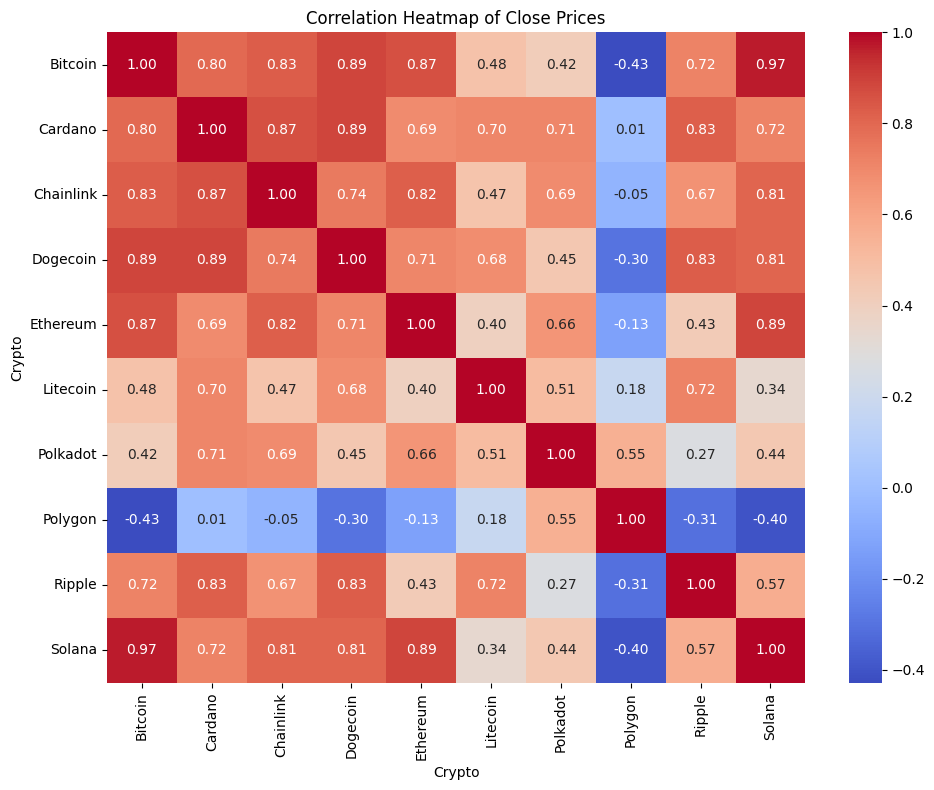

In [7]:
close_pivot = df.pivot(index='Timestamp', columns='Crypto', values='Close')
correlation_matrix = close_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Close Prices")
plt.tight_layout()
plt.show()


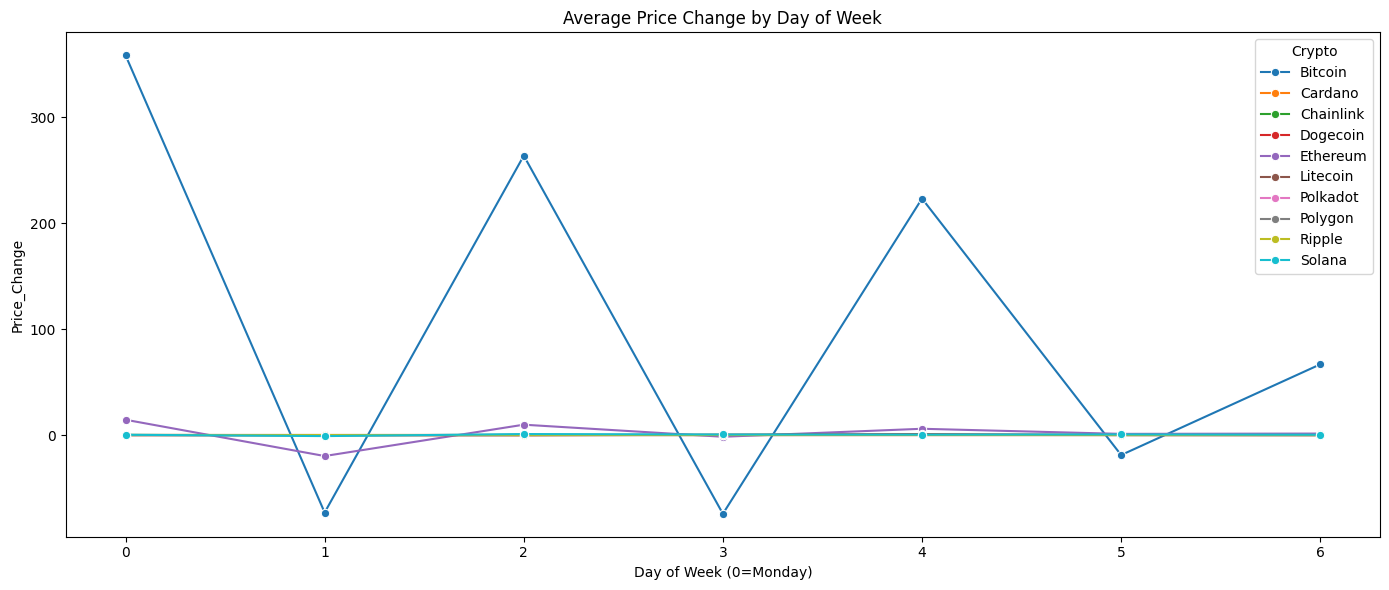

In [8]:
dow_mean = df.groupby(['Crypto', 'Day_of_Week'])['Price_Change'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=dow_mean, x='Day_of_Week', y='Price_Change', hue='Crypto', marker='o')
plt.title("Average Price Change by Day of Week")
plt.xlabel("Day of Week (0=Monday)")
plt.tight_layout()
plt.show()

C:\Users\anand\AppData\Local\Temp\ipykernel_17332\403033064.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rsi_counts = df.groupby(['Crypto', 'RSI_Zone']).size().reset_index(name='Counts')


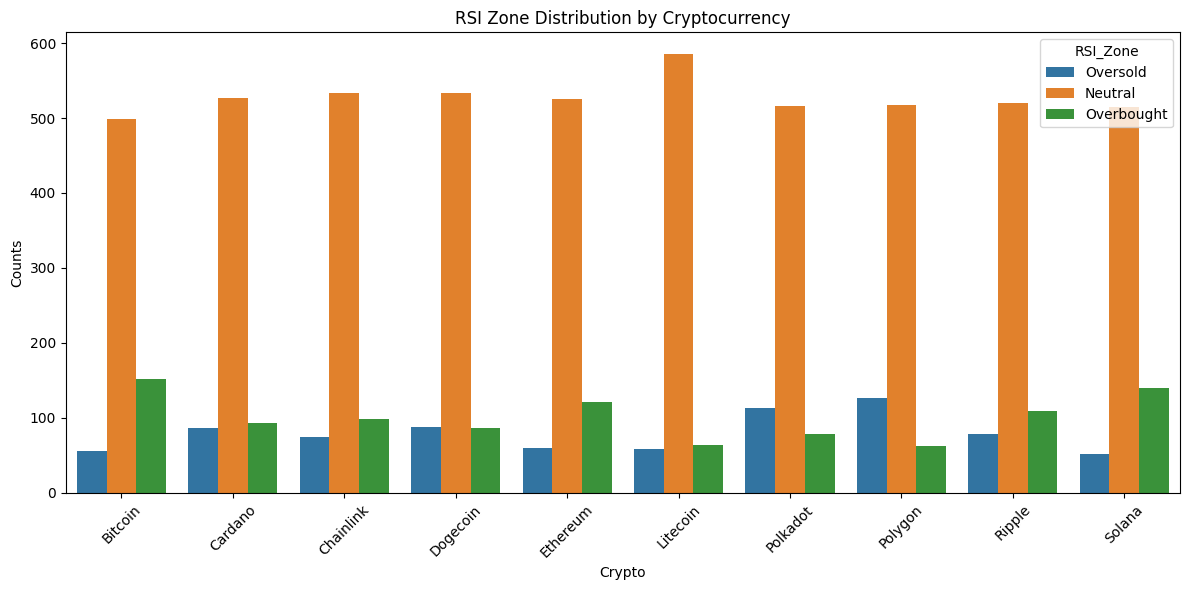

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

df['RSI_Zone'] = pd.cut(df['RSI'], bins=[0, 30, 70, 100], labels=['Oversold', 'Neutral', 'Overbought'])

rsi_counts = df.groupby(['Crypto', 'RSI_Zone']).size().reset_index(name='Counts')

plt.figure(figsize=(12, 6))
sns.barplot(data=rsi_counts, x='Crypto', y='Counts', hue='RSI_Zone')
plt.title("RSI Zone Distribution by Cryptocurrency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

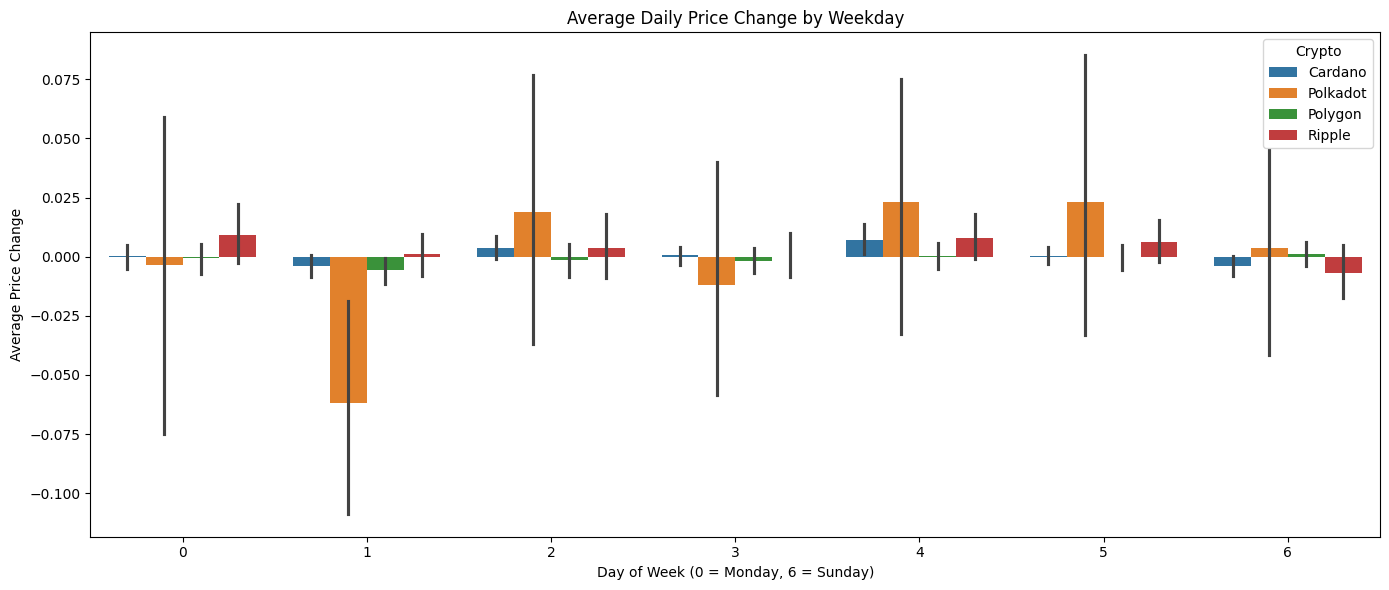

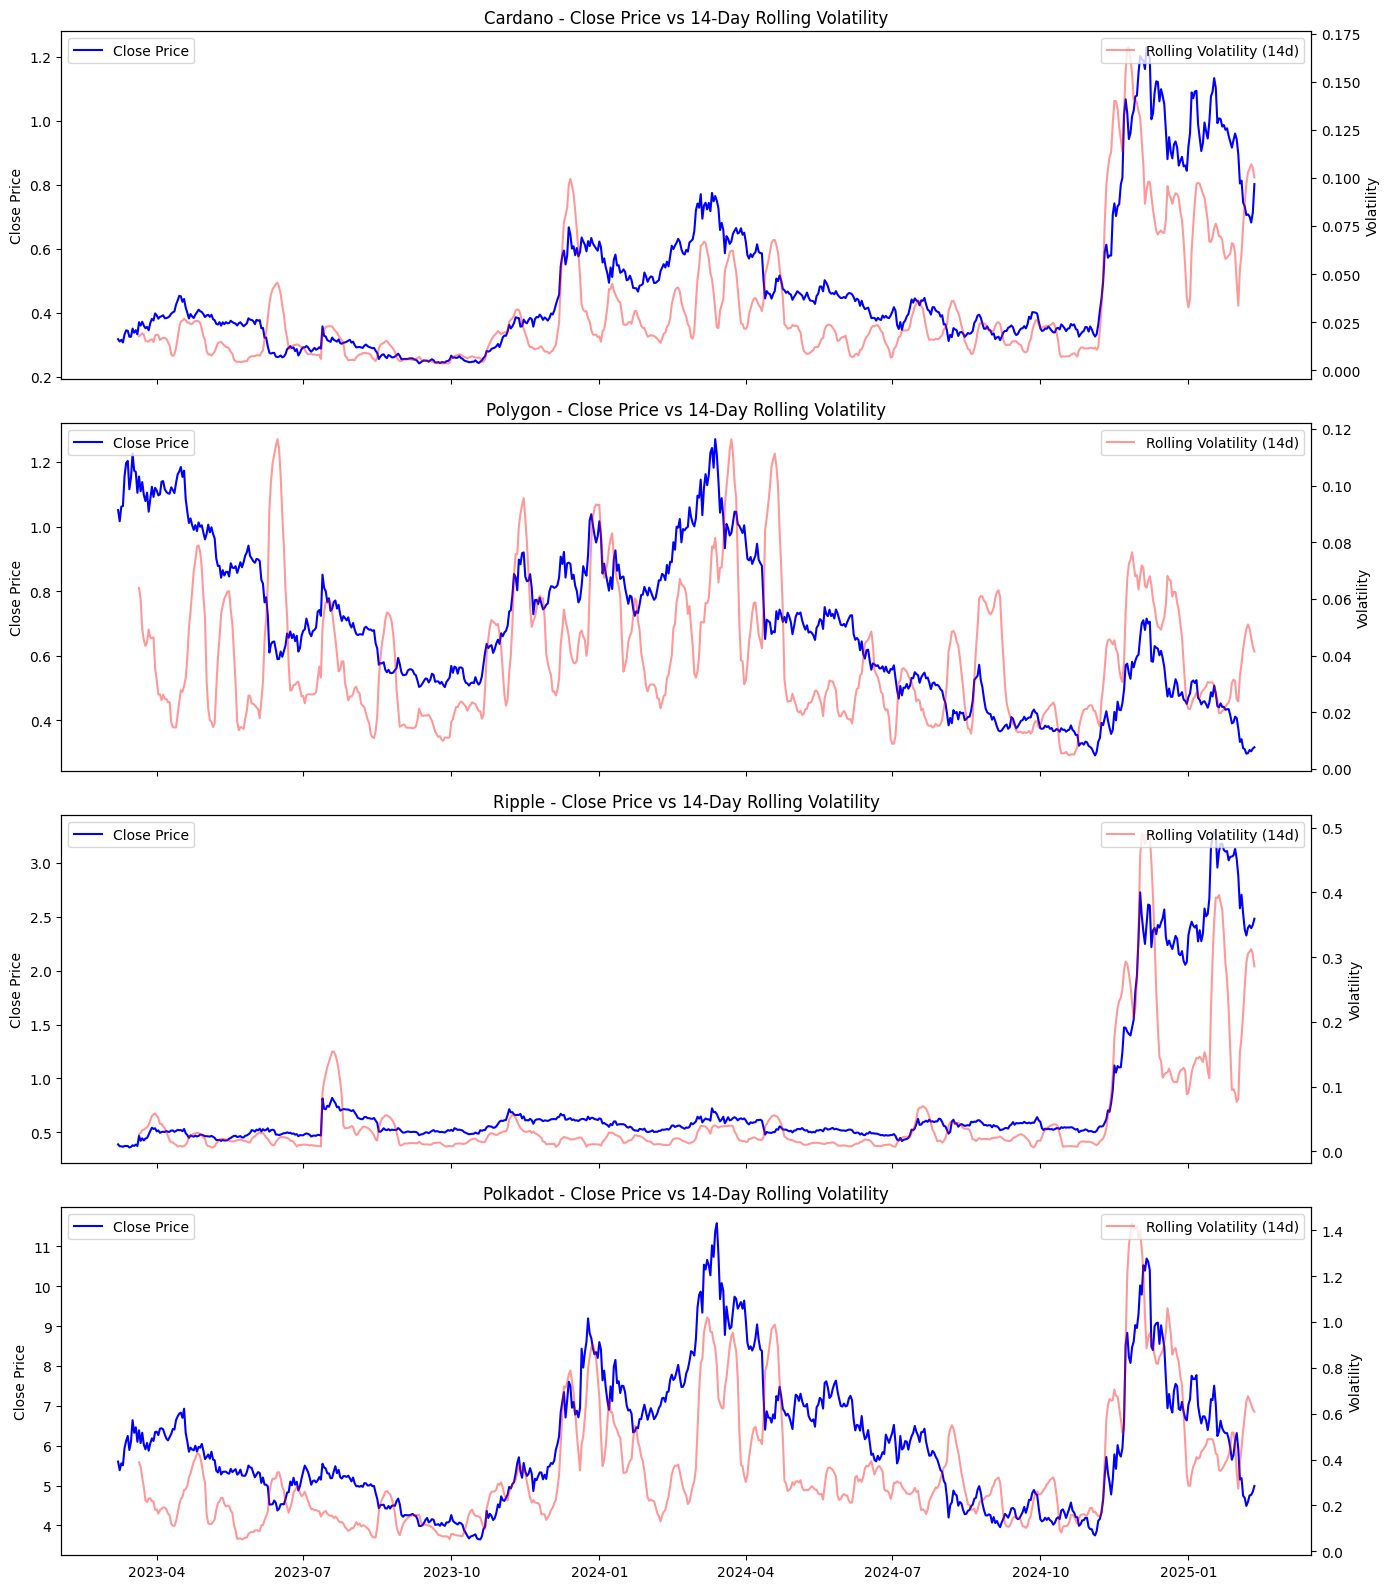

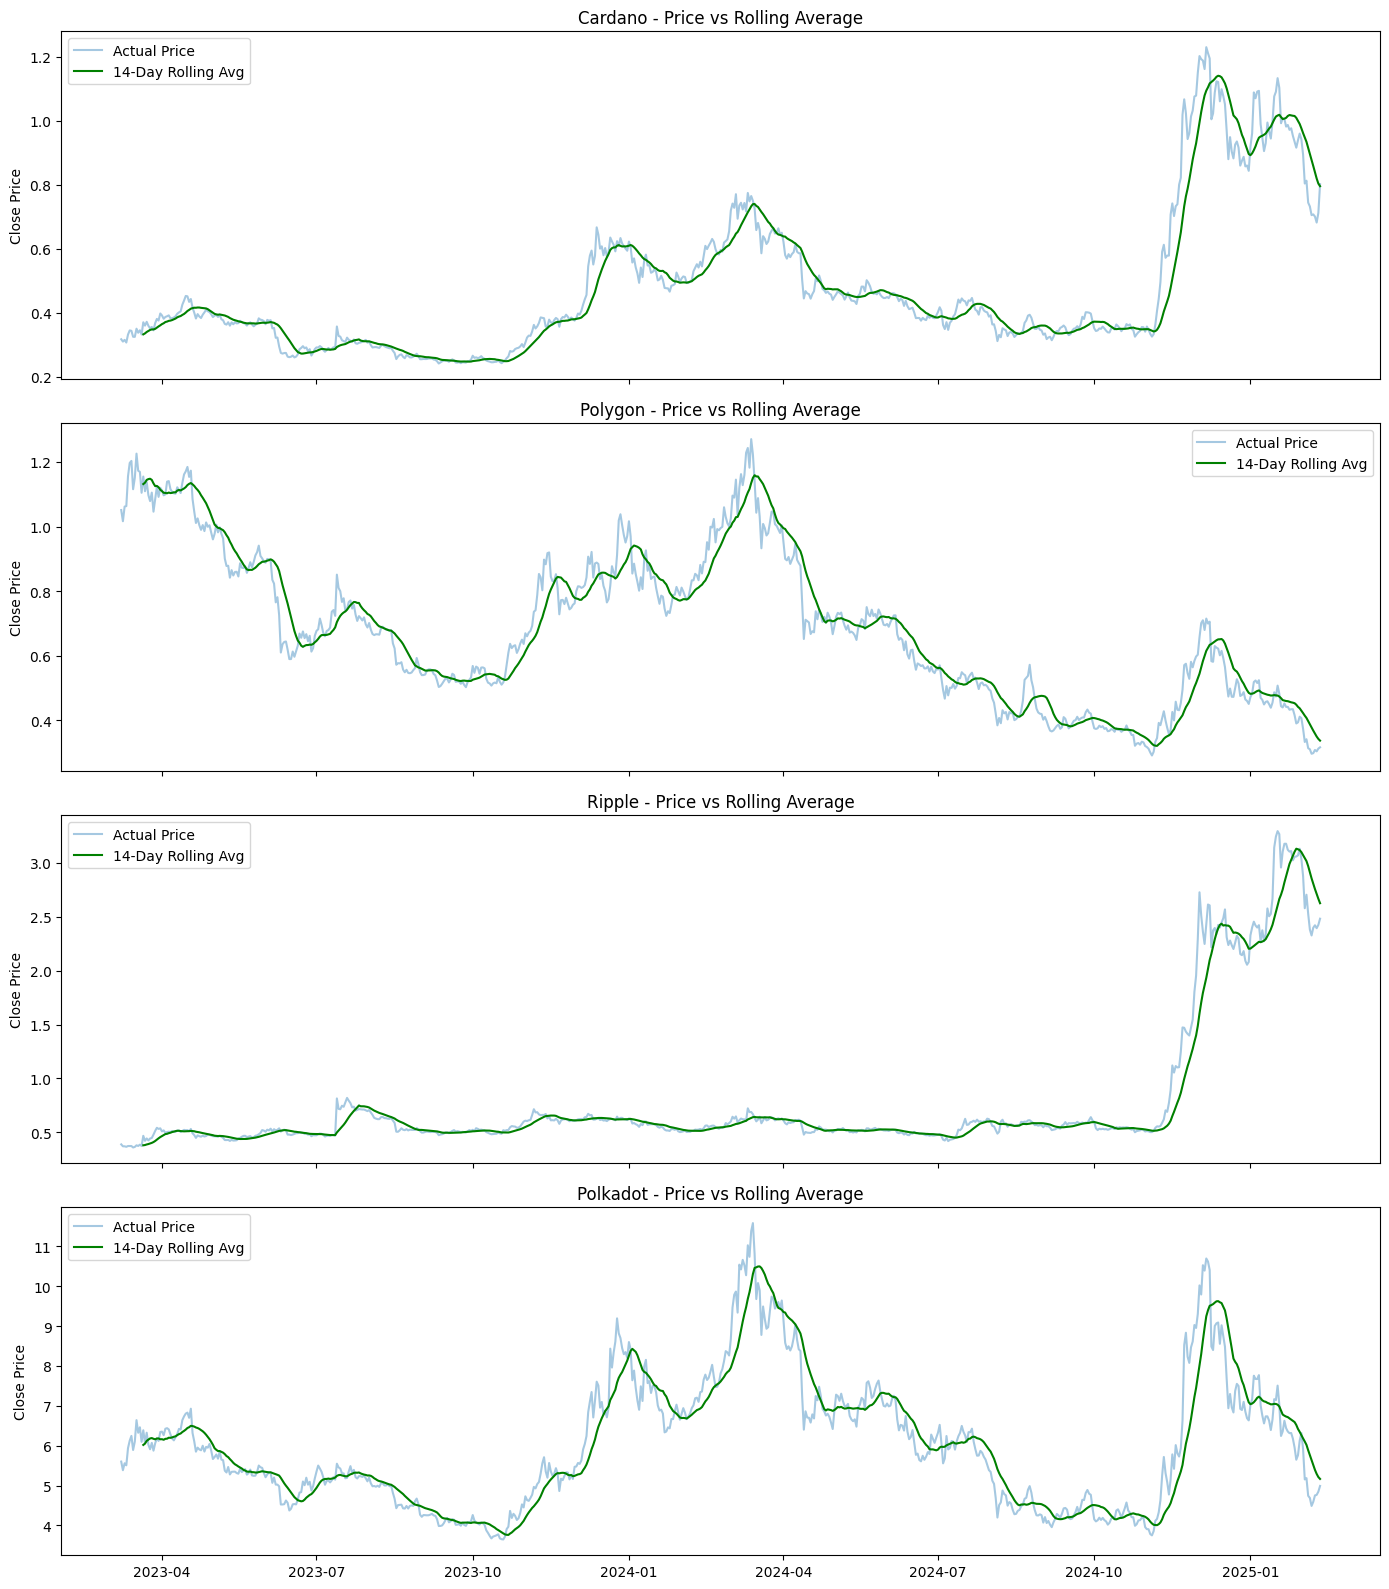

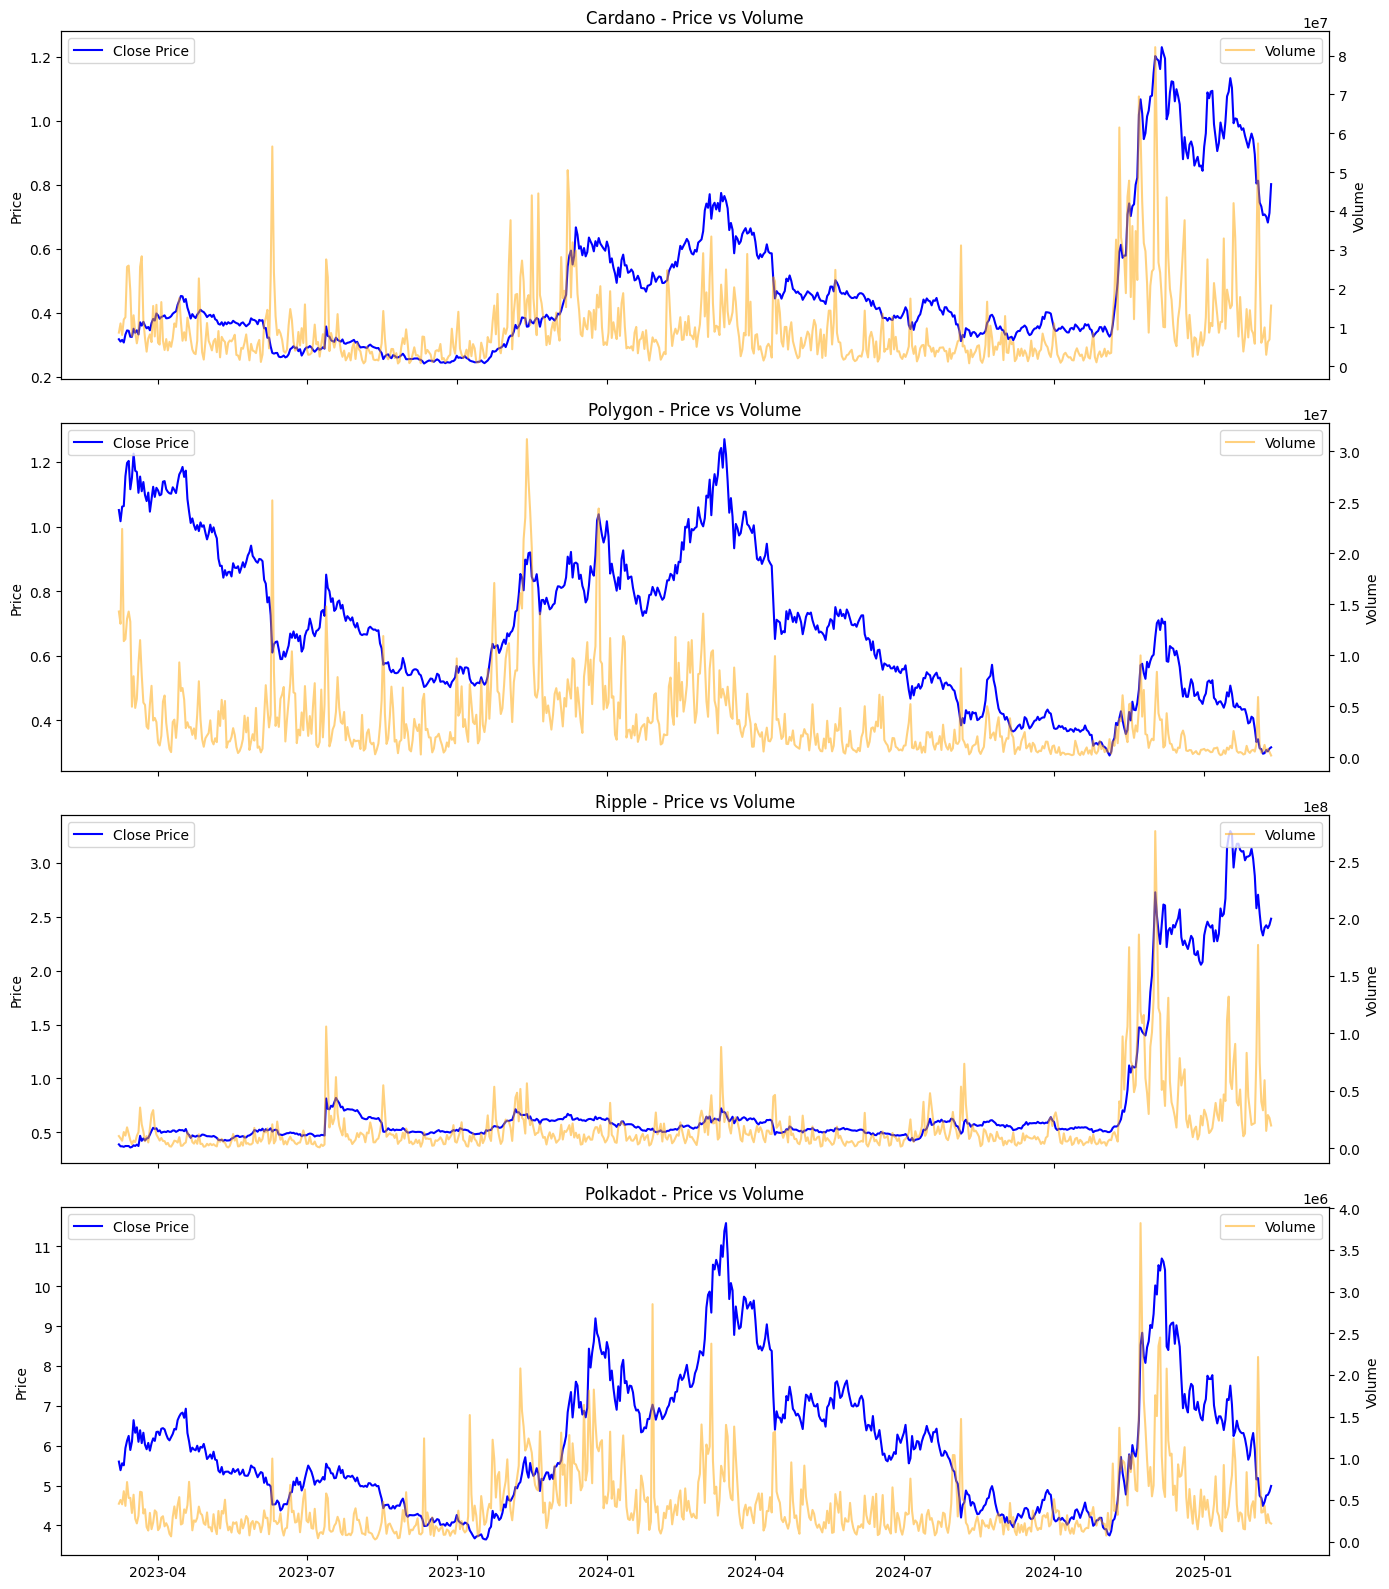

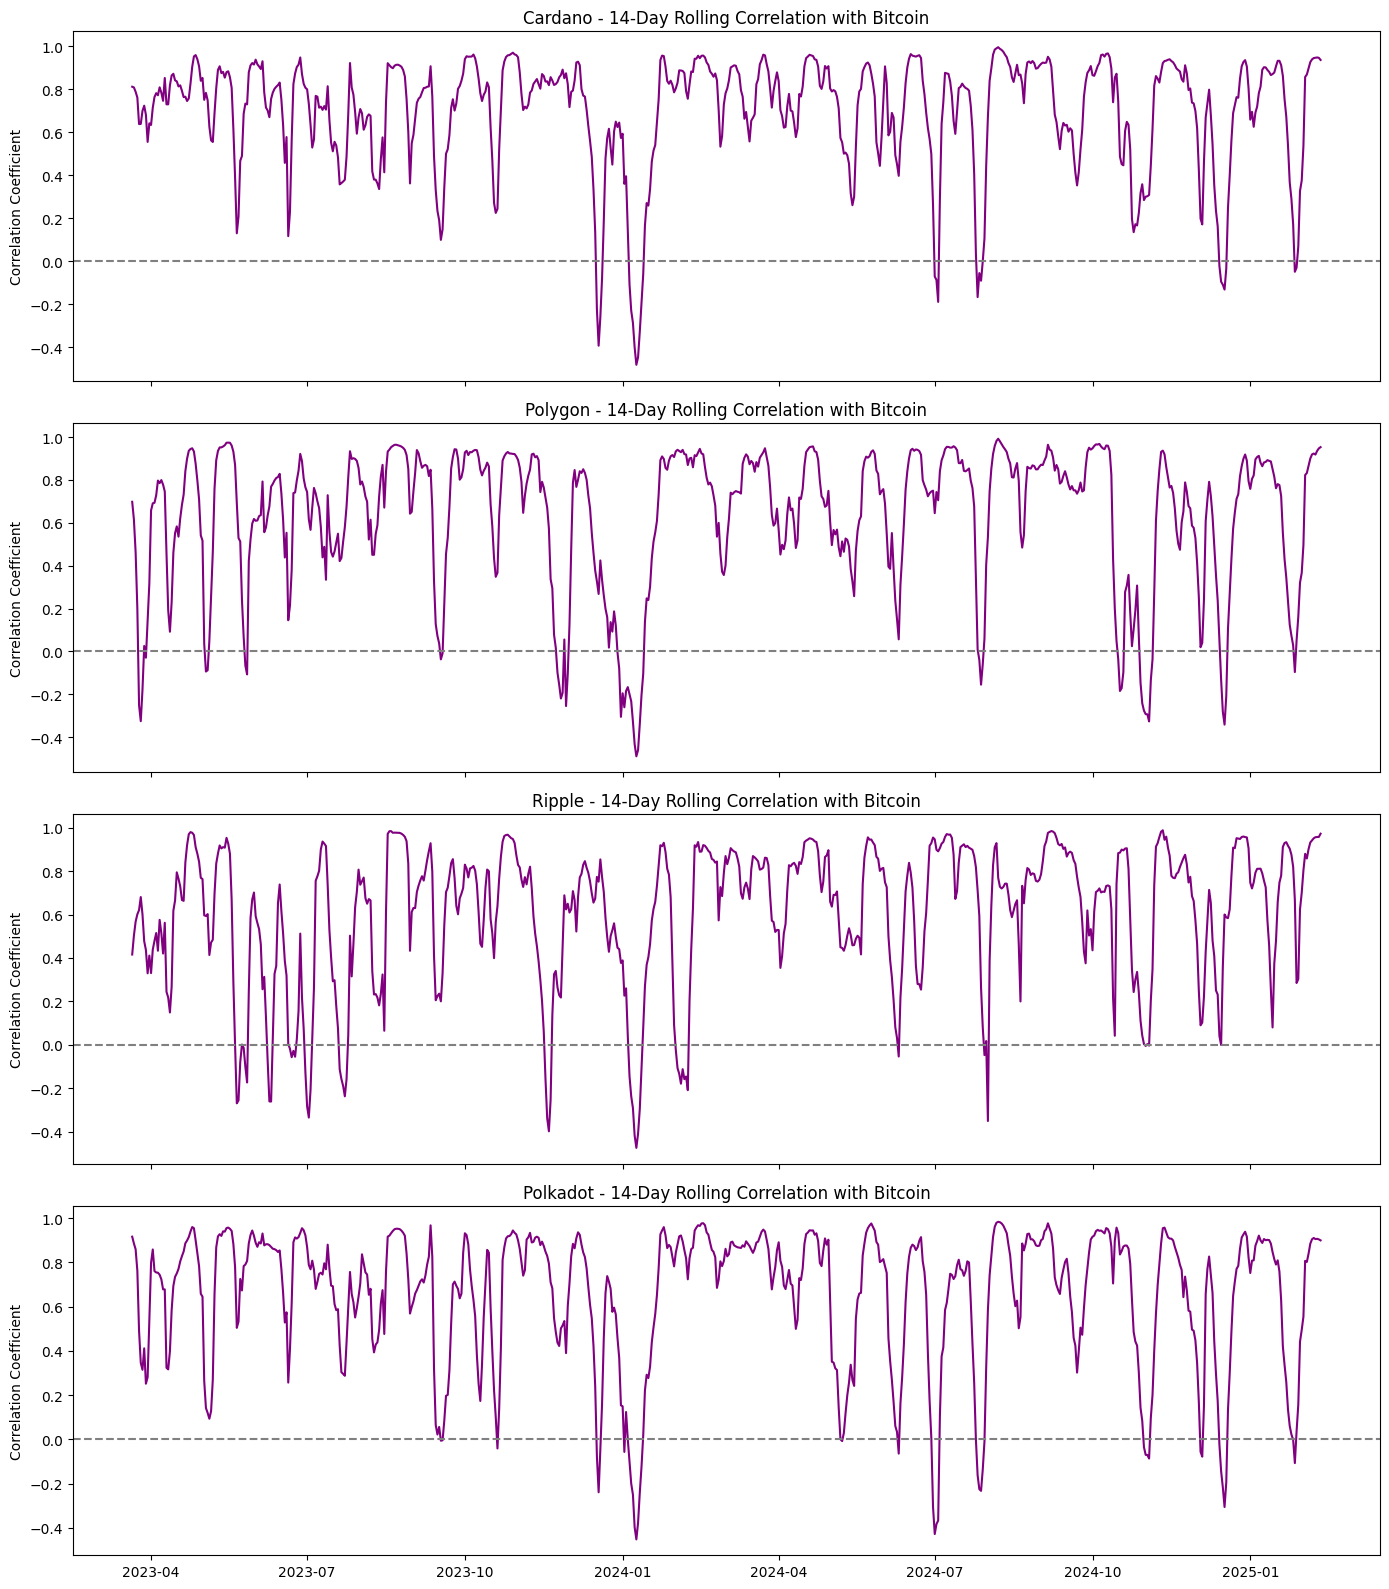

In [14]:
# Add Polkadot to the target coins list
target_coins = ['Cardano', 'Polygon', 'Ripple', 'Polkadot']
df_filtered = df[df['Crypto'].isin(target_coins)].copy()

# ---------- 1. Weekly Trend Analysis ----------
plt.figure(figsize=(14, 6))
sns.barplot(data=df_filtered, x='Day_of_Week', y='Price_Change', hue='Crypto', estimator=np.mean)
plt.title("Average Daily Price Change by Weekday")
plt.xlabel("Day of Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Average Price Change")
plt.legend(title='Crypto')
plt.tight_layout()
plt.show()

# ---------- 2. Rolling Volatility vs Close Price ----------
window = 14
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 16), sharex=True)

for i, coin in enumerate(target_coins):
    coin_df = df_filtered[df_filtered['Crypto'] == coin].copy()
    coin_df = coin_df.sort_values('Timestamp')
    coin_df['Rolling_Volatility'] = coin_df['Close'].rolling(window=window).std()
    
    ax = axes[i]
    ax.plot(coin_df['Timestamp'], coin_df['Close'], label='Close Price', color='blue')
    ax2 = ax.twinx()
    ax2.plot(coin_df['Timestamp'], coin_df['Rolling_Volatility'], label='Rolling Volatility (14d)', color='red', alpha=0.4)
    ax.set_title(f"{coin} - Close Price vs 14-Day Rolling Volatility")
    ax.set_ylabel("Close Price")
    ax2.set_ylabel("Volatility")
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# ---------- 3. Rolling Average Trend ----------
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 16), sharex=True)

for i, coin in enumerate(target_coins):
    coin_df = df_filtered[df_filtered['Crypto'] == coin].copy()
    coin_df = coin_df.sort_values('Timestamp')
    coin_df['Rolling_Mean'] = coin_df['Close'].rolling(window=14).mean()

    axes[i].plot(coin_df['Timestamp'], coin_df['Close'], label='Actual Price', alpha=0.4)
    axes[i].plot(coin_df['Timestamp'], coin_df['Rolling_Mean'], label='14-Day Rolling Avg', color='green')
    axes[i].set_title(f"{coin} - Price vs Rolling Average")
    axes[i].set_ylabel("Close Price")
    axes[i].legend()

plt.tight_layout()
plt.show()

# ---------- 4. Volume Divergence ----------
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 16), sharex=True)

for i, coin in enumerate(target_coins):
    coin_df = df_filtered[df_filtered['Crypto'] == coin].copy()
    coin_df = coin_df.sort_values('Timestamp')

    axes[i].plot(coin_df['Timestamp'], coin_df['Close'], label='Close Price', color='blue')
    ax2 = axes[i].twinx()
    ax2.plot(coin_df['Timestamp'], coin_df['Volume'], label='Volume', color='orange', alpha=0.5)
    axes[i].set_title(f"{coin} - Price vs Volume")
    axes[i].set_ylabel("Price")
    ax2.set_ylabel("Volume")
    axes[i].legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# ---------- 5. Correlation with Bitcoin ----------
btc_df = df[df['Crypto'] == 'Bitcoin'][['Timestamp', 'Close']].rename(columns={'Close': 'BTC_Close'})

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 16), sharex=True)

for i, coin in enumerate(target_coins):
    coin_df = df_filtered[df_filtered['Crypto'] == coin][['Timestamp', 'Close']]
    merged = pd.merge(coin_df, btc_df, on='Timestamp')
    rolling_corr = merged['Close'].rolling(window=14).corr(merged['BTC_Close'])

    axes[i].plot(merged['Timestamp'], rolling_corr, color='purple')
    axes[i].set_title(f"{coin} - 14-Day Rolling Correlation with Bitcoin")
    axes[i].set_ylabel("Correlation Coefficient")
    axes[i].axhline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()


## 🔁 Prediction & Evaluation Function (Loads Saved LSTM Model)

In [ ]:
def evaluate_lstm_model(df, crypto_name, model_path, sequence_length=10):
    print(f"\n Evaluating model for: {crypto_name}")
    features = ['Open', 'High', 'Low', 'Volume', 'VWAP', 'Volatility', 'Price_Change',
                'RSI', 'MACD', 'MA_7', 'MA_14', 'EMA_7', 'EMA_14', 'Rolling_Std_7',
                'Rolling_Std_14', 'Day_of_Week', 'Month', 'Week_of_Year',
                'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']
    target = 'Close'
    crypto_df = df[df['Crypto'] == crypto_name].drop(columns=['Crypto']).dropna().reset_index(drop=True)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(crypto_df[features])
    y_scaled = scaler_y.fit_transform(crypto_df[[target]])

    def create_sequences(X, y, seq_len):
        Xs, ys = [], []
        for i in range(seq_len, len(X)):
            Xs.append(X[i - seq_len:i])
            ys.append(y[i])
        return np.array(Xs), np.array(ys)

    X, y = create_sequences(X_scaled, y_scaled, sequence_length)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = load_model(model_path)
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"📊 RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Plot predictions
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title(f"{crypto_name} - Forecast vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

    # SHAP interpretation
    try:
        X_sample = X_test[:100]
        explainer = shap.Explainer(lambda x: model.predict(x), X_sample)
        shap_values = explainer(X_sample)
        shap.summary_plot(shap_values, X_sample, plot_type='bar')
    except Exception as e:
        print(f"⚠️ SHAP skipped due to error: {e}")

    return {'rmse': rmse, 'mae': mae, 'r2': r2}


## 🗂️ Evaluate Models for All Coins

In [ ]:
model_paths = {
    "Bitcoin": "LSTM_Bitcoin.h5",
    "Ethereum": "LSTM_Ethereum.h5",
    "Cardano": "LSTM_Cardano.h5",
    "Ripple": "LSTM_Ripple.h5",
    "Solana": "LSTM_Solana.h5",
    "Litecoin": "LSTM_Litecoin.h5",
    "Polkadot": "LSTM_Polkadot.h5",
    "Polygon": "LSTM_Polygon.h5",
    "Chainlink": "LSTM_Chainlink.h5",
    "Dogecoin": "LSTM_Dogecoin.h5"
}

results = {}
for coin, path in model_paths.items():
    print(f"🔍 Evaluating: {coin}")
    results[coin] = evaluate_lstm_model(df, crypto_name=coin, model_path=path)


# SARIMAX

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import warnings
warnings.filterwarnings("ignore")


def full_sarimax_pipeline(df, crypto_name, lags=['Close_Lag_1', 'MACD', 'EMA_7'], season_length=7, save_model=True):
    coin_df = df[df['Crypto'] == crypto_name].copy()
    coin_df.set_index('Timestamp', inplace=True)

    endog = coin_df['Close']
    exog = coin_df[lags]

    print(f"🔍 Performing ADF test on {crypto_name} Close prices...")
    adf_result = adfuller(endog)
    print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")

    d = 0
    if adf_result[1] >= 0.05:
        d = 1
        endog = endog.diff().dropna()
        exog = exog.loc[endog.index]  # realign exog after differencing
        print("➡️ Differencing applied (d=1)")
        adf_result_diff = adfuller(endog)
        print(f"Post-Differencing ADF: {adf_result_diff[0]:.4f}, p-value: {adf_result_diff[1]:.4f}")
    else:
        print("✅ Data is stationary (d=0)")

    # Plot ACF/PACF
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(endog, ax=ax[0])
    plot_pacf(endog, ax=ax[1])
    ax[0].set_title("ACF")
    ax[1].set_title("PACF")
    plt.suptitle(f"{crypto_name} - ACF and PACF")
    plt.tight_layout()
    plt.show()

    # Grid search
    print("🔁 Performing grid search for best SARIMAX parameters...")
    p = d_range = q = range(0, 3)
    P = D = Q = range(0, 2)
    s = [season_length]

    best_mae = float("inf")
    best_cfg = None
    best_model = None

    for params in itertools.product(p, [d], q, P, D, Q, s):
        try:
            order = params[:3]
            seasonal_order = params[3:]
            model = SARIMAX(endog, exog=exog, order=order, seasonal_order=seasonal_order)
            result = model.fit(disp=False)
            forecast = result.forecast(steps=30, exog=exog.iloc[-30:])
            mae = mean_absolute_error(coin_df['Close'].iloc[-30:], forecast)
            if mae < best_mae:
                best_mae = mae
                best_cfg = (order, seasonal_order)
                best_model = result
        except:
            continue

    print(f"✅ Best Config for {crypto_name}: Order={best_cfg[0]}, Seasonal={best_cfg[1]}, MAE={best_mae:.4f}")

    # Evaluate on test data
    test_size = int(len(coin_df) * 0.2)
    test_y = coin_df['Close'].iloc[-test_size:]
    test_exog = coin_df[lags].iloc[-test_size:]

    predictions = best_model.forecast(steps=test_size, exog=test_exog)
    predictions.index = test_y.index

    rmse = np.sqrt(mean_squared_error(test_y, predictions))
    mae = mean_absolute_error(test_y, predictions)
    r2 = r2_score(test_y, predictions)

    metrics = {"RMSE": rmse, "MAE": mae, "R²": r2}
    print(f"📊 Evaluation Metrics: {metrics}")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(test_y.index, test_y.values, label="Actual", color="blue")
    plt.plot(predictions.index, predictions.values, label="SARIMAX Predicted", color="orange", linestyle="--")
    plt.title(f"{crypto_name} - Actual vs SARIMAX")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if save_model:
        best_model.save(f"SARIMAX_{crypto_name}.pkl")
        print(f"💾 SARIMAX model saved as SARIMAX_{crypto_name}.pkl")

    return {"metrics": metrics, "model": best_model, "pred": predictions, "truth": test_y}




# Compare LSTM with SARIMAX

In [ ]:
crypto_list = ["Bitcoin", "Ethereum", "Cardano", "Ripple", "Solana", 
               "Litecoin", "Polkadot", "Polygon", "Chainlink", "Dogecoin"]

lstm_paths = {c: f"LSTM_{c}.h5" for c in crypto_list}

comparison_results = {}

for crypto in crypto_list:
    print(f"🔎 Comparing models for {crypto}...")
    sarimax_res = evaluate_sarimax_model(df, crypto)
    lstm_res = evaluate_lstm_model(df, crypto, lstm_paths[crypto])

    metrics_df = pd.DataFrame({
        "Model": ["SARIMAX", "LSTM"],
        "MAE": [sarimax_res["mae"], lstm_res["mae"]],
        "RMSE": [sarimax_res["rmse"], lstm_res["rmse"]],
        "R2": [sarimax_res["r2"], lstm_res["r2"]]
    })
    print(metrics_df)

    plt.figure(figsize=(12, 5))
    plt.plot(sarimax_res["truth"].index, sarimax_res["truth"], label="Actual", color="blue")
    plt.plot(sarimax_res["truth"].index, sarimax_res["pred"], label="SARIMAX", linestyle="--", color="orange")
    plt.plot(sarimax_res["truth"].index[-len(lstm_res["pred"]):], lstm_res["pred"], label="LSTM", linestyle=":", color="green")
    plt.title(f"{crypto} – Actual vs LSTM vs SARIMAX")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    comparison_results[crypto] = metrics_df.set_index("Model")